In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
generative = combinators.BroadcastingTrace(1)

In [4]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [5]:
ssm_step = combinators.Model(ssm.ssm_step)

In [6]:
for t in range(zs.shape[0] - 1):
    zs[t+1], mu, sigma, delta = ssm_step((zs[t], mu, sigma, delta), t, trace=generative)

In [7]:
data = generative.unwrap(lambda k, rv: 'X_' in k)

In [8]:
num_particles = 100

In [9]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [10]:
init_ssm_generative = combinators.Model(ssm.init_ssm, hyper=ssm_params)
ssm_step_generative = combinators.Model(ssm.ssm_step)
smc_ssm = importance.ImportanceResampler.smc(ssm_step_generative, 50, initializer=init_ssm_generative)

In [11]:
init_ssm_proposal = combinators.Model(ssm.init_ssm, trainable=ssm_params)
ssm_step_proposal = combinators.Model(ssm.ssm_step)
ssm_proposal = combinators.Model.compose(
    combinators.Model.sequence(ssm_step_proposal, 50),
    init_ssm_proposal, intermediate_name='initializer'
)

In [12]:
ssm_importance = importance.ImportanceSampler(model=smc_ssm, proposal=ssm_proposal)

In [13]:
inference, init_ssm_params, elbos = importance.variational_importance(
    num_particles, ssm_importance, 2000,
    data, use_cuda=False, lr=1e-1, patience=500
)

10/09/2018 11:55:18 ELBO=-1.49490845e+02 at epoch 1
10/09/2018 11:55:19 ELBO=-2.16787262e+02 at epoch 2
10/09/2018 11:55:19 ELBO=-1.82078064e+02 at epoch 3
10/09/2018 11:55:19 ELBO=-3.98843781e+02 at epoch 4
10/09/2018 11:55:20 ELBO=-3.52880554e+02 at epoch 5
10/09/2018 11:55:20 ELBO=-1.93555176e+02 at epoch 6
10/09/2018 11:55:21 ELBO=-1.95643524e+02 at epoch 7
10/09/2018 11:55:21 ELBO=-2.96074707e+02 at epoch 8
10/09/2018 11:55:22 ELBO=-2.17974518e+02 at epoch 9
10/09/2018 11:55:22 ELBO=-2.58572113e+02 at epoch 10
10/09/2018 11:55:23 ELBO=-1.81718582e+02 at epoch 11
10/09/2018 11:55:23 ELBO=-3.54639282e+02 at epoch 12
10/09/2018 11:55:24 ELBO=-2.19462723e+02 at epoch 13
10/09/2018 11:55:24 ELBO=-1.71766754e+02 at epoch 14
10/09/2018 11:55:25 ELBO=-1.54698639e+02 at epoch 15
10/09/2018 11:55:25 ELBO=-2.97661804e+02 at epoch 16
10/09/2018 11:55:25 ELBO=-2.21531754e+02 at epoch 17
10/09/2018 11:55:26 ELBO=-1.76353714e+02 at epoch 18
10/09/2018 11:55:27 ELBO=-2.63065704e+02 at epoch 19
10

Epoch  1577: reducing learning rate of group 0 to 5.0000e-02.


10/09/2018 12:05:08 ELBO=-1.25442345e+02 at epoch 1579
10/09/2018 12:05:08 ELBO=-1.58074097e+02 at epoch 1580
10/09/2018 12:05:09 ELBO=-2.00748383e+02 at epoch 1581
10/09/2018 12:05:09 ELBO=-1.93011261e+02 at epoch 1582
10/09/2018 12:05:09 ELBO=-1.48047440e+02 at epoch 1583
10/09/2018 12:05:10 ELBO=-1.76166382e+02 at epoch 1584
10/09/2018 12:05:10 ELBO=-1.34526062e+02 at epoch 1585
10/09/2018 12:05:10 ELBO=-2.12071350e+02 at epoch 1586
10/09/2018 12:05:11 ELBO=-1.67382706e+02 at epoch 1587
10/09/2018 12:05:11 ELBO=-1.17296822e+02 at epoch 1588
10/09/2018 12:05:11 ELBO=-1.63716797e+02 at epoch 1589
10/09/2018 12:05:12 ELBO=-1.71800140e+02 at epoch 1590
10/09/2018 12:05:12 ELBO=-1.37882874e+02 at epoch 1591
10/09/2018 12:05:12 ELBO=-1.45619598e+02 at epoch 1592
10/09/2018 12:05:12 ELBO=-1.66988251e+02 at epoch 1593
10/09/2018 12:05:13 ELBO=-1.57556946e+02 at epoch 1594
10/09/2018 12:05:13 ELBO=-1.42129913e+02 at epoch 1595
10/09/2018 12:05:13 ELBO=-1.47273407e+02 at epoch 1596
10/09/2018

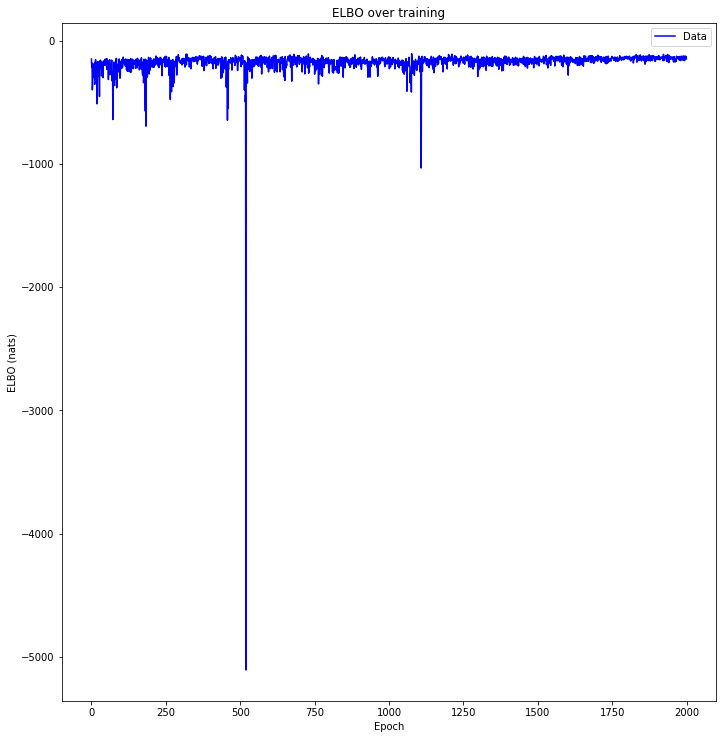

In [14]:
utils.plot_evidence_bounds(elbos)

In [15]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.639496
SMC MSE at time 2: 0.616542
SMC MSE at time 3: 0.516392
SMC MSE at time 4: 0.006470
SMC MSE at time 5: 0.046070
SMC MSE at time 6: 0.000441
SMC MSE at time 7: 0.519064
SMC MSE at time 8: 1.825971
SMC MSE at time 9: 0.714276
SMC MSE at time 10: 0.426928
SMC MSE at time 11: 1.603995
SMC MSE at time 12: 16.552074
SMC MSE at time 13: 22.233383
SMC MSE at time 14: 27.326332
SMC MSE at time 15: 30.790691
SMC MSE at time 16: 26.707396
SMC MSE at time 17: 31.403082
SMC MSE at time 18: 34.670235
SMC MSE at time 19: 47.599823
SMC MSE at time 20: 55.056644
SMC MSE at time 21: 49.443275
SMC MSE at time 22: 43.444202
SMC MSE at time 23: 54.704796
SMC MSE at time 24: 51.306767
SMC MSE at time 25: 63.746548
SMC MSE at time 26: 60.633179
SMC MSE at time 27: 65.112633
SMC MSE at time 28: 67.512535
SMC MSE at time 29: 74.155670
SMC MSE at time 30: 86.912079
SMC MSE at time 31: 109.375153
SMC MSE at time 32: 102.261551
SMC MSE at time 33: 102.793365
SMC MSE at time 34: 89.7636

In [16]:
particle_mh = mcmc.IndependentMH(smc_ssm, ssm_proposal, 1000)

In [17]:
samples, elbos = particle_mh(trace=importance.ResamplerTrace(num_particles, data=data))
inference = particle_mh.trace

In [18]:
inference

Trace{'mu': Normal([torch.FloatTensor of size 100]), 'sigma': Normal([torch.FloatTensor of size 100]), 'delta': Normal([torch.FloatTensor of size 100]), 'Z_0': Normal([torch.FloatTensor of size 100]), 'Z_1': Normal([torch.FloatTensor of size 100]), 'X_1': Normal([torch.FloatTensor of size 100]), 'Z_2': Normal([torch.FloatTensor of size 100]), 'X_2': Normal([torch.FloatTensor of size 100]), 'Z_3': Normal([torch.FloatTensor of size 100]), 'X_3': Normal([torch.FloatTensor of size 100]), 'Z_4': Normal([torch.FloatTensor of size 100]), 'X_4': Normal([torch.FloatTensor of size 100]), 'Z_5': Normal([torch.FloatTensor of size 100]), 'X_5': Normal([torch.FloatTensor of size 100]), 'Z_6': Normal([torch.FloatTensor of size 100]), 'X_6': Normal([torch.FloatTensor of size 100]), 'Z_7': Normal([torch.FloatTensor of size 100]), 'X_7': Normal([torch.FloatTensor of size 100]), 'Z_8': Normal([torch.FloatTensor of size 100]), 'X_8': Normal([torch.FloatTensor of size 100]), 'Z_9': Normal([torch.FloatTenso

In [19]:
generative

Trace{'Z_1': Normal([torch.FloatTensor of size 1]), 'X_1': Normal([torch.FloatTensor of size 1]), 'Z_2': Normal([torch.FloatTensor of size 1]), 'X_2': Normal([torch.FloatTensor of size 1]), 'Z_3': Normal([torch.FloatTensor of size 1]), 'X_3': Normal([torch.FloatTensor of size 1]), 'Z_4': Normal([torch.FloatTensor of size 1]), 'X_4': Normal([torch.FloatTensor of size 1]), 'Z_5': Normal([torch.FloatTensor of size 1]), 'X_5': Normal([torch.FloatTensor of size 1]), 'Z_6': Normal([torch.FloatTensor of size 1]), 'X_6': Normal([torch.FloatTensor of size 1]), 'Z_7': Normal([torch.FloatTensor of size 1]), 'X_7': Normal([torch.FloatTensor of size 1]), 'Z_8': Normal([torch.FloatTensor of size 1]), 'X_8': Normal([torch.FloatTensor of size 1]), 'Z_9': Normal([torch.FloatTensor of size 1]), 'X_9': Normal([torch.FloatTensor of size 1]), 'Z_10': Normal([torch.FloatTensor of size 1]), 'X_10': Normal([torch.FloatTensor of size 1]), 'Z_11': Normal([torch.FloatTensor of size 1]), 'X_11': Normal([torch.Flo

In [20]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 3.168084
SMC MSE at time 2: 2.306619
SMC MSE at time 3: 2.610514
SMC MSE at time 4: 4.673028
SMC MSE at time 5: 5.656041
SMC MSE at time 6: 5.569802
SMC MSE at time 7: 7.625900
SMC MSE at time 8: 15.120204
SMC MSE at time 9: 15.463941
SMC MSE at time 10: 18.129097
SMC MSE at time 11: 16.356384
SMC MSE at time 12: 14.558015
SMC MSE at time 13: 18.601469
SMC MSE at time 14: 23.579988
SMC MSE at time 15: 27.014122
SMC MSE at time 16: 23.935844
SMC MSE at time 17: 31.276152
SMC MSE at time 18: 36.184933
SMC MSE at time 19: 49.148922
SMC MSE at time 20: 56.324020
SMC MSE at time 21: 51.731247
SMC MSE at time 22: 46.452866
SMC MSE at time 23: 57.068878
SMC MSE at time 24: 52.163921
SMC MSE at time 25: 64.401756
SMC MSE at time 26: 62.434189
SMC MSE at time 27: 67.845940
SMC MSE at time 28: 69.005676
SMC MSE at time 29: 72.715706
SMC MSE at time 30: 85.378731
SMC MSE at time 31: 101.006287
SMC MSE at time 32: 96.587814
SMC MSE at time 33: 93.657959
SMC MSE at time 34: 82.73

In [21]:
elbos

tensor([-156.6856, -129.7942, -129.7942, -129.7942, -117.3787, -117.3787,
        -117.3787, -117.3787, -117.3787, -117.3787, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -117.3981,
        -117.3981, -117.3981, -117.3981, -117.3981, -117.3981, -110.0454,
        -110.0454, -110.0454, -110.0454, -110.0454, -110.0454, -110.0454,
        -110.0454, -110.0454, -110.0454, -110.0454, -110.0454, -110.0454,
        -110.0454, -110.0454, -110.0454, -110.0454, -110.0454, -110.0454,
        -110.0454, -110.0454, -110.045